# Práctica NLP: Ejercicio 1. Descarga y EDA
## Library Imports

In [1]:
!pip install wordcloud
!pip install stop_words
!pip install gensim
!pip install pyLDAvis

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from collections import Counter
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from nltk import ngrams
from nltk.probability import FreqDist
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# Uploading the data
We will use the following Amazon reviews from the link: http://jmcauley.ucsd.edu/data/amazon/

We will take the datasets related to the categories **Amazon Instant Video** and **Digital Music**.

In [3]:
# Dataset: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz
# Descargamos el dataset
!wget -O 'digital_music.json.gz' 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz'
!wget -O 'video.json.gz' 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz'

--2021-07-03 19:49:59--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32052614 (31M) [application/x-gzip]
Saving to: ‘digital_music.json.gz’

digital_music.json. 100%[===================>]  30.57M  16.8MB/s    in 1.8s    

2021-07-03 19:50:01 (16.8 MB/s) - ‘digital_music.json.gz’ saved [32052614/32052614]

--2021-07-03 19:50:01--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9517526 (9.1M) [application/x-gzip]
Saving to: ‘video.json.gz’

video.json.gz       100%[===================>

#Data Exploration

In [4]:
df_digital_music = pd.read_json('digital_music.json.gz', lines=True, compression='gzip')
df_video = pd.read_json('video.json.gz', lines=True, compression='gzip')

In [5]:
df_digital_music.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [6]:
df_video.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [7]:
df_digital_music.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008"


In [8]:
df_digital_music.shape

(64706, 9)

In [9]:
df_video.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


In [10]:
df_video.shape

(37126, 9)

In [11]:
# We will take 1500 good and bad reviews to create a better and equal corpus
df_digital_music.loc[:, 'opinion'] = [1 if rank < 3 else 0 for rank in df_digital_music['overall']]
df_video.loc[:, 'opinion'] = [1 if rank < 3 else 0 for rank in df_video['overall']]


review_amount = 1500
df_digital_music = df_digital_music.groupby('opinion', group_keys=False).apply(lambda x: x.sample(min(len(x), review_amount)))
df_video = df_video.groupby('opinion', group_keys=False).apply(lambda x: x.sample(min(len(x), review_amount)))

df_digital_music = df_digital_music[['reviewText', 'overall', 'opinion']]
df_video = df_video[['reviewText', 'overall', 'opinion']]

df_digital_music.head()

,reviewText,overall,opinion
61094,I initially bought this album for a song I hea...,5,0
189,Pet Sounds is one of those albums (like Sgt. P...,5,0
18340,This is one of the first Madonna albums I list...,4,0
25080,It's amazing how much emotion Gary Numan was a...,5,0
54347,The first thing you notice when you spin (or i...,4,0


In [12]:
# Function that returns n-grams
def get_vocabulary(df, col_name):   
    words_ = []
    bigrams_ = []
    trigrams_ = []
    
    for review in df[col_name]:
        for word in review.split():
            words_.append(word)
    
    bigrams_ = list(ngrams(words_, 2))
    trigrams_ = list(ngrams(words_, 3))
    
    vocab = {
        'words': words_,
        'bigrams': bigrams_,
        'trigrams': trigrams_
    }
    
    return vocab

In [13]:
digital_music_words = get_vocabulary(df_digital_music, 'reviewText')
video_words = get_vocabulary(df_video, 'reviewText')

print('DIGITAL MUSIC')
print('10 common words:\n{}'.format(Counter(digital_music_words['words']).most_common(10)))
print('\n10 common bigramas:\n{}'.format(Counter(digital_music_words['bigrams']).most_common(10)))
print('\n10 common trigramas:\n{}'.format(Counter(digital_music_words['trigrams']).most_common(10)))

print('\n\nVIDEO WORDS')
print('10 common words:\n{}'.format(Counter(video_words['words']).most_common(10)))
print('\n10 common bigramas:\n{}'.format(Counter(video_words['bigrams']).most_common(10)))
print('\n10 common trigramas:\n{}'.format(Counter(video_words['trigrams']).most_common(10)))

DIGITAL MUSIC
10 common words:
[('the', 21947), ('and', 13744), ('a', 11838), ('of', 11592), ('to', 10575), ('is', 9813), ('I', 6947), ('this', 6252), ('that', 5785), ('in', 5153)]

10 common bigramas:
[(('of', 'the'), 2833), (('in', 'the'), 1458), (('is', 'a'), 1434), (('on', 'the'), 1216), (('this', 'album'), 1135), (('to', 'the'), 986), (('and', 'the'), 890), (('one', 'of'), 830), (('to', 'be'), 794), (('is', 'the'), 734)]

10 common trigramas:
[(('one', 'of', 'the'), 462), (('is', 'one', 'of'), 240), (('this', 'album', 'is'), 240), (('a', 'lot', 'of'), 192), (('the', 'rest', 'of'), 171), (('some', 'of', 'the'), 170), (('rest', 'of', 'the'), 165), (('on', 'this', 'album'), 157), (('of', 'the', 'songs'), 142), (('of', 'the', 'best'), 142)]


VIDEO WORDS
10 common words:
[('the', 14945), ('and', 8646), ('to', 7898), ('a', 7782), ('of', 7240), ('I', 5489), ('is', 5481), ('in', 3851), ('that', 3527), ('it', 3290)]

10 common bigramas:
[(('of', 'the'), 1776), (('in', 'the'), 945), (('and

In [14]:
# Word cloud function to show words in a cloud
def plot_word_cloud(text, title):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(12,6))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

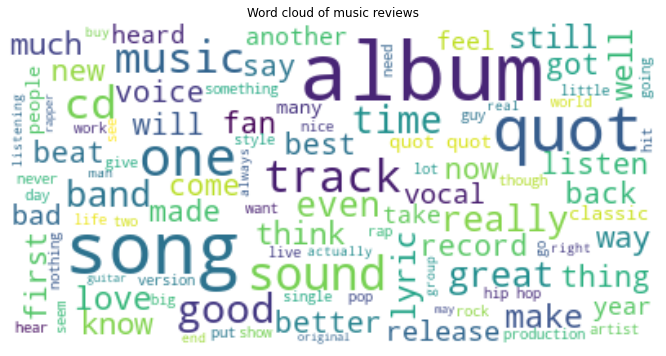

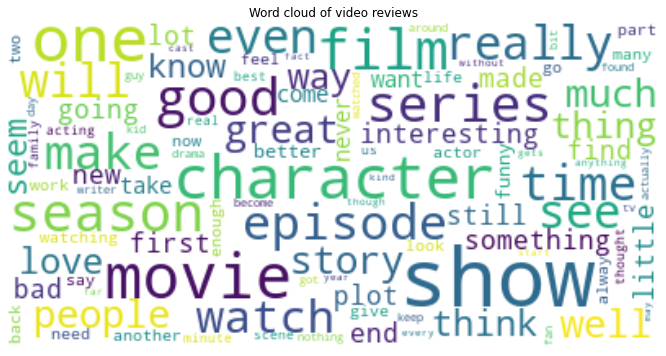

In [15]:
plot_word_cloud(' '.join(digital_music_words['words']).lower().strip().split(), 'Word cloud of {} reviews'.format('music'))
plot_word_cloud(' '.join(video_words['words']).lower().strip().split(), 'Word cloud of {} reviews'.format('video'))

5    1853
2    1571
1    1429
4     795
3     352
Name: overall, dtype: int64

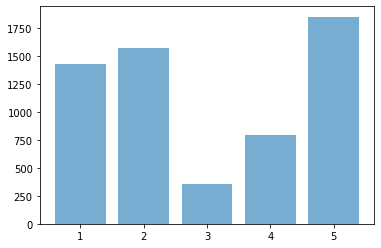

In [16]:
# We now unify both datasets
df = pd.concat([df_digital_music, df_video])

fig, ax = plt.subplots()

puntuation = df['overall'].value_counts()

x = puntuation.index
height = puntuation.values
bar_obj = ax.bar(x = x, height = height, alpha=.6); puntuation

In [17]:
# We will save the result so we can explore it in another notebook
df.to_csv('corpus.csv', index=False)

In [18]:
# We divide the corpus to use the Word2Vec
corpus = df['reviewText'].sample(500)
corpus = corpus.str.split()

In [19]:
w2v_model = Word2Vec(
    sg=1,
    size=300,
    min_count=5,
    window=5,
    hs=0,
    negative=20,
    workers=4
)
w2v_model.build_vocab(corpus)

w2v_model.train(sentences=corpus, total_examples=w2v_model.corpus_count, epochs=20)
w2v_model.save('../w2v.pkl')

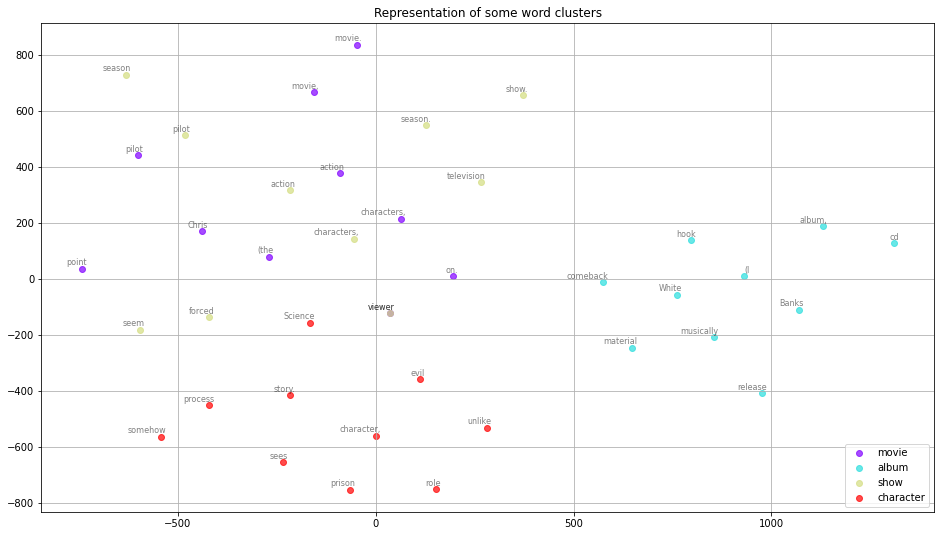

In [20]:
# We choose several words that seem key
keys = ['movie', 'album', 'show', 'character']

embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)  

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)  
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape 
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))
for key, embeddings, words, color in zip(keys, embeddings_2d, word_clusters, colors):
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=[color], alpha=0.7, label=key)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                      textcoords='offset points', ha='right', va='bottom', size=8)
plt.legend(loc=4)
plt.grid(True)
plt.title('Representation of some word clusters')
plt.show()

##Conclusion
- We see that we need to better clean the corpus, it seems that most of the words are not useful.
- The words shown seem to be correctly connected.